# PacMan

## Restrições para análise do projeto

- Não são permitidos movimentos na **diagonal**, apenas, **cima**, **baixo**, **esquerda** e **direita**.
- Pacman não passa mais de uma vez pela mesma célula (busca deve levar em conta posições exploradas).
- O objetivo do problema é sempre o mesmo: apenas chegar na posição objetivo com o menor custo (dependente de quantas moedas o pacman coletar).
- As soluções são qualificadas por custo onde, para cada movimento que o pacman fizer, há um custo associado a posição destino que pode assumir 3 valores diferentes: custo se a posição não conter nada, custo se houver uma moeda ou custo se houver uma moeda grande - tudo definido no construtor da classe *Maze*.
- A não ser que seja especificado, os 3 diferentes custos são:
    - Espaço livre: 10
    - Moeda (Coin): 2
    - Grande Moeda (Big Coin): 1


## Observações sobre a implementação 

- Mapas são registrados em um arquivo *.txt* e devem ser formatados corretamente: com o mesmo número de caracteres em cada linha, apenas um pacman - posicao inicial **(P)** e pelo menos um objetivo **(X)**.
- Estado definido por tupla **(x, y)** - posição no mapa.

### Importações de bibliotecas

In [180]:
%matplotlib inline
import time
from enum import Enum
from aima.search import *
from aima.utils import *
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import random
import pandas as pd
from IPython.display import Markdown, display

In [181]:
def plot_image(*images, titles = [], table_format=(1, 0), figsize=(15, 15), axis=False, fontsize=20):
    '''
    Função auxiliar para comparar diferentes soluções (por imagens)
    '''
    max_lines = table_format[0] if table_format[0]!=0 else len(images)
    max_columns = table_format[1] if table_format[1]!=0 else len(images)

    fig = plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        ax = fig.add_subplot(max_lines, max_columns, i+1)
        
        if len(titles)==len(images):
            ax.set_xlabel(titles[i], fontsize=fontsize)
        
        if axis is False:
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.xaxis.set_ticks_position('none') 
            ax.yaxis.set_ticks_position('none') 
        if isinstance(image, str):
            ax.axis('off')
            ax.text(0, 0.5, image, horizontalalignment='left', fontsize=fontsize+4,
                    verticalalignment='center', transform=ax.transAxes)
        else:
            ax.imshow(image)
    plt.show()
    
def plot_mazes_images(maze_file_names):
    images = []
    titles = []
    maze_names = maze_file_names
    
    if (len(maze_names) == 0):
        maze_names = os.listdir('mazes')

    for maze_name in maze_names:
        maze = Maze(os.path.join('mazes', maze_name))
        images.append(maze.get_map_image())
        titles.append(maze_name)
    
    plot_image(*images, titles=titles, table_format=(0,3), figsize=(20, 40))
    
def plot_graph(maze_file_names, solver_function, distance_function, x = 'distance', y = 'path_cost', kind = 'line'):
    '''
    Função auxiliar para desenhar gráficos utilizando posições aleatórias de objetivos
    '''
    if (len(maze_file_names) == 0):
        return

    for maze_file_name in maze_file_names:
        maze = Maze('mazes/' + maze_file_name)
        data_frame = random_analysis(maze, 100, [solver_function[0], *solver_function[1:]], distance_function)
        data_frame.sort_values(x).plot(x = x, y = y, kind = kind)

    plt.show()

### Gerenciador do labirinto

In [182]:
class PosType(Enum):
    '''
    Enumerado com caracteres possiveis para representação do labirinto
    '''
    FREE = (' ', (0, 0, 0, 0))
    COIN = ('.', 'coin.png')
    B_COIN = ('o', 'b_coin.png')
    WALL = ('|', (0, 0, 204, 255))
    GHOST = ('G', 'ghost.png')
    PACMAN = ('P', 'pacman.png')
    GOAL = ('X', (0, 255, 0, 255))
    PATH = ('+', (52, 180, 235, 255))
    
    def __new__(cls, *args, **kwds):
        obj = object.__new__(cls)
        obj._value_ = args[0]
        return obj

    def __init__(self, char, sprite):
        self.char = char
        if isinstance(sprite, str):
            black = np.full((14, 14, 4), (0, 0, 0, 0), dtype=np.uint8)
            background = Image.fromarray(black)
            foreground = Image.open(os.path.join('sprites', sprite))
            background.paste(foreground, (0, 0), foreground)
            self.sprite = np.asarray(background)
        else:
            self.sprite = np.full((14, 14, 4), sprite)
    
    @staticmethod
    def valid_inits():
        '''
        Retorna todos os enumerados validos que podem estar contidos em arquivo txt
        '''
        return [ptype for ptype in PosType if ptype not in [PosType.PATH]]

    @staticmethod
    def valid_pacman_positions():
        '''
        Retorna os enumerados onde o pacman pode se movimentar
        '''
        return [PosType.FREE, PosType.COIN, PosType.B_COIN, PosType.GOAL, PosType.PACMAN]

In [6]:
class Maze:
    '''
    Classe para ler arquivos txt representativos dos labirintos e comportamento dos elementos ao interagir
    com o pacman

    :self.w: largura do mapa
    :self.h: altura do mapa
    :self.initial_state: estado inicial (x, y)
    :self.goal_states: lista de estados objetivos [(x, y)]
    :self.free_cost: custo de uma célula livre
    :self.coin_cost: custo moeda simples
    :self.bcoin_cost: custo de uma moeda grande
    '''

    def __init__(self, filepath, free_cost=10, coin_cost=2, bcoin_cost=1):
        # Classe construtora para um maze - ler arquivo e guarda em uma lista de strings
        # Faz algumas checagens para prevenir formatos errados
        file = open(filepath, "r")
        self._maze = file.read().splitlines()
        file.close()
        self.w = len(self._maze[0])
        self.h = len(self._maze)
        self.initial_state = None
        self.goal_states = []
        self.free_cost = free_cost
        self.coin_cost = coin_cost
        self.bcoin_cost = bcoin_cost

        for y in range(self.h):
            if len(self._maze[y]) is not self.w:
                raise ValueError('Invalid map dimensions')
            else:
                # Percorre linhas obtidas pelo arquivo procurando por seugestao de posicao inicial do
                # pacman e os objetivos (se houverem), há uma simples checagem de formato invalido de mapa
                for x in range(self.w):
                    pos = (x, y)
                    if self.get(pos) is PosType.PACMAN:
                        if self.initial_state is None:
                            self.initial_state = pos
                        else:
                            raise ValueError('Multiple pacmans position')
                    elif self.get(pos) is PosType.GOAL:
                        self.goal_states.append(pos)
                    elif self.get(pos) not in PosType.valid_inits():
                        raise ValueError('Invalid char {}'.format(self._maze[y][x]))

                # Remove objetivos e pacman do mapa
                self._maze[y] = self._maze[y].replace(PosType.PACMAN.value, ' ').replace(PosType.GOAL.value, ' ')

    def get(self, pos):
        # definimos _maze[y][x]
        return PosType(self._maze[pos[1]][pos[0]])

    def get_cost(self, pos):
        # retorna o custo de acordo com a posicao
        ptype = self.get(pos)
        if ptype == PosType.COIN:
            return self.coin_cost
        elif ptype == PosType.B_COIN:
            return self.bcoin_cost
        else:
            return self.free_cost

    def possible_positions(self, pos):
        '''
        Retorna possiveis posicoes que o pacman consegue chegar a partir de pos
        :pos: posição do pacman (x, y)
        return lista de posicoes (x, y)
        '''
        x, y = pos[0], pos[1]
        possible_positions = []
        for step in [(0, -1), (1, 0), (0, 1), (-1, 0)]:  # up, right, down, left
            # soma os steps com x, e y, tomando cuidados com os limites transversais do mapa
            newX = self.w - 1 if x + step[0] < 0 else (x + step[0]) % self.w
            newY = self.h - 1 if y + step[1] < 0 else (y + step[1]) % self.h
            pos = (newX, newY)
            if self.get(pos) in PosType.valid_pacman_positions():
                possible_positions.append(pos)

        return possible_positions

    def __str__(self):
        string = ''
        for line in self._maze:
            string = string + line + '\n'
        return string

    @staticmethod
    def _print(maze):
        for line in maze:
            print(''.join(line))
        print('\n')
        
    @staticmethod
    def _put_initial_and_goals(maze_list, initial_state, goal_states):
        maze_list[initial_state[1]][initial_state[0]] = PosType.PACMAN.value
        for goal in goal_states:
            maze_list[goal[1]][goal[0]] = PosType.GOAL.value
        return maze_list

    @staticmethod
    def _put_solution(maze_list, solution):
        for state in solution:
            maze_list[state[1]][state[0]] = PosType.PATH.value
        return maze_list
    
    def _copy_maze_list(self):
        maze = list()
        for line in self._maze:
            maze.append(list(line))
            
        return maze
    
    def _get_solution(self, solution):
        maze = self._copy_maze_list()
        Maze._put_solution(maze, solution)
        Maze._put_initial_and_goals(maze, self.initial_state, self.goal_states)
        return maze
    
    def _get_map(self):
        maze = self._copy_maze_list()
        Maze._put_initial_and_goals(maze, self.initial_state, self.goal_states)
        return maze
    
    def print_solution(self, solution):
        '''
        Printa solucao
        :solution: lista de posicoes que levam a solucao [(x, y) ...]
        '''
        Maze._print(self._get_solution(solution))

    def print_map(self):
        '''
        Printa mapa com posicao inical e objetivo
        '''
        Maze._print(maze._get_map())
        
    def _get_map_image(self):
        maze = self._get_map()
        image = np.zeros((14*self.h, 14*self.w, 4), dtype=np.uint8)
        for x in range(self.w): 
            for y in range(self.h):
                image[y*14:(y+1)*14, x*14:(x+1)*14] = PosType(maze[y][x]).sprite
        return image
    
    def get_map_image(self):
        return self._get_map_image()[:,:,:3]
    
    def get_solution_image(self, solution):
        solution.append(self.initial_state)
        foreground = Image.fromarray(self._get_map_image())
        
        background = np.full((14*self.h, 14*self.w, 4), (0, 0, 0, 255), dtype=np.uint8)
        for (x, y) in solution:
            background[y*14:(y+1)*14, x*14:(x+1)*14] = PosType.PATH.sprite
        background = Image.fromarray(background)
        background.paste(foreground, (0, 0), foreground)
        image = np.asarray(background)
        return image[:,:,:3]
        
    def plot_map(self):
        plot_image(self.get_map_image())
        
    def plot_solution(self, solution):
        plot_image(self.get_solution_image(solution))

### Definição da classe problema

In [183]:
from aima.search import Problem

class MazePacmanProblem(Problem):
    '''
    Define o conjunto de ações, resultados, custo, e teste objetivo para o problema
    '''

    def __init__(self, maze):
        '''
        Instancia um objeto problema
        :initial: estado inicial do pacman - posicao por uma tupla (x, y)
        :goal: estado final, obejtivo do pacman - posição por uma tupla (x, y) ou lista de tuplas
        '''
        Problem.__init__(self, maze.initial_state, maze.goal_states)
        self.maze = maze

    def actions(self, state):
        return self.maze.possible_positions(state)

    def result(self, state, action):
        return action

    def goal_test(self, state):
        if isinstance(self.goal, list):
            return state in self.goal
        else:
            return state == self.goal

    def path_cost(self, cost_so_far, stateA, action, stateB):
        # custo do caminho é incrementado com o custo da proxima célula
        return cost_so_far + self.maze.get_cost(action)
    
    def value(self, state):
        [xGoal, yGoal] = self.goal[0]
        [xState, yState] = state

        value = abs(xGoal - xState) + abs(yGoal - yState)

        return value

### Classe, funções auxiliares

In [184]:
class Statistics:
    '''
    Classe para auxiliar/organizar as metragens de estatisticas dos algoritmos
    :self.iterations: numero de iteracoes
    :self.expanded: numero de nos expandidos pelo algoritmo
    :self.memory: pico de memoria (numero maximo de estados salvos ao mesmo tempo)
    :self.time: tempo em ms
    :self.path_cost: custo total da solução
    '''

    def __init__(self, iterations=0, expanded=1, memory=1, distance=None):
        self.iterations = iterations
        self.expanded = expanded
        self.memory = memory
        self.time = None
        self.path_cost = None
        self.distance = None
        self._start_time = time.time()

    def update_iterations(self, increment):
        self.iterations = self.iterations + increment

    def update_expanded(self, increment):
        self.expanded = self.expanded + increment

    def update_memory(self, new_memory):
        if new_memory > self.memory:
            self.memory = new_memory

    def finish(self, path_cost):
        '''
        Finaliza o timer (aberto no construtor) e salva custo da solucao
        '''
        self.path_cost = path_cost
        self.time = time.time() - self._start_time
        
    def items(self):
        dict_items = self.__dict__.copy()
        del dict_items['_start_time']
        return dict_items

    def __str__(self):
        string = ''
        string = string + "Distancia para solução: {}\n".format(self.distance)
        string = string + "Número de iterações: {}\n".format(self.iterations)
        string = string + "Número de nós expandidos: {}\n".format(self.expanded)
        string = string + "Estados salvos (memória máxima): {}\n".format(self.memory)
        string = string + "Tempo real: {}s\n".format(self.time)
        string = string + "Custo da solução: {}".format(self.path_cost)

        return string

In [185]:
def manhattan_distance(pos, maze):
    '''
    Distancia  manhattan considerando regioes transversaveis
    '''
    
    distances = []
    for goal in maze.goal_states:
        x_distance = min(abs(goal[0]-pos[0]), abs(goal[0]-(pos[0]+maze.w)), abs(goal[0]-(pos[0]-maze.w)))
        y_distance = min(abs(goal[1]-pos[1]), abs(goal[1]-(pos[1]+maze.h)), abs(goal[1]-(pos[1]-maze.h)))
        distances.append(x_distance+y_distance)
        
    return min(distances)

In [186]:
def random_analysis(maze, n_analysis, solver_function, distance_function=manhattan_distance):
    '''
    Sorteia 'n_analysis' posicoes válidas do mapa 'maze' e resolve com a solver_function
    :solver_function: lista com o primeiro elemento com ponteiro para a função para resolver o problema 
    e os proximos os parametros (excluindo o 'problem')
    '''
    statistics_list = []
    i = 0
    random.seed(42)
    while i < n_analysis:    
        random_goal = (random.randrange(0, maze.w), random.randrange(0, maze.h))
        # verifica se a posicao gerada pode ser considerada objetivo
        if (maze.get(random_goal) in [PosType.FREE, PosType.COIN, PosType.B_COIN, PosType.GOAL]):
            maze.goal_states = [random_goal]
            distance = distance_function(maze.initial_state, maze)
            problem = MazePacmanProblem(maze)
            statistics, node = solver_function[0](problem, *solver_function[1:])
            statistics.distance = distance 
            #maze.plot_solution(node.solution())
            statistics_list.append(statistics.items())
            i = i + 1
            
    return pd.DataFrame(statistics_list)

In [187]:
def analysis_mazes(mazes_list, solver_function_list, figsize=None, mazeargs=[]):
    '''
    Função para facilitar comparações visuais de soluções entre diferentes mapas e algoritmos
    :solver_function_list: lista de solver_functions, onde cada elemento é também uma lista com primeiro elemento
    do tipo ponteiro para a função, segundo o nome do método utilizado para gerar texto e legendas, e o restante
    os parametros opcionais que essa função pode necessitar desconsiderando a instancia do problema
    '''
    # Heuristica para um bom tamanho da figura a ser exibida
    if figsize==None:
        figsize = (20, 18*len(solver_function_list))
        
    for maze_name in mazes_list:
        maze = Maze(os.path.join('mazes', maze_name), *mazeargs)
        map_image = maze.get_map_image()
        images = []
        titles = []
        for i, solver_function in enumerate(solver_function_list):
            problem = MazePacmanProblem(maze)
            statistics, node = solver_function[0](problem, *solver_function[2:])
            statistics.distance = manhattan_distance(maze.initial_state, maze)
            solution_image = maze.get_solution_image(node.solution())
            statistics_text = '{}\n\n{}'.format(solver_function[1], statistics)
            images.extend([solution_image, statistics_text])
            titles.extend(["Figura {}: Solução do labirinto {} utilizando {}".format(
                i+1, maze_name, solver_function[1]), ''])
        display(Markdown('### {}'.format(maze_name)))
        plot_image(*images, titles=titles, table_format=(0, 2), figsize=figsize, fontsize=15)
        print('\n\n')

# Labirintos utilizados nos testes

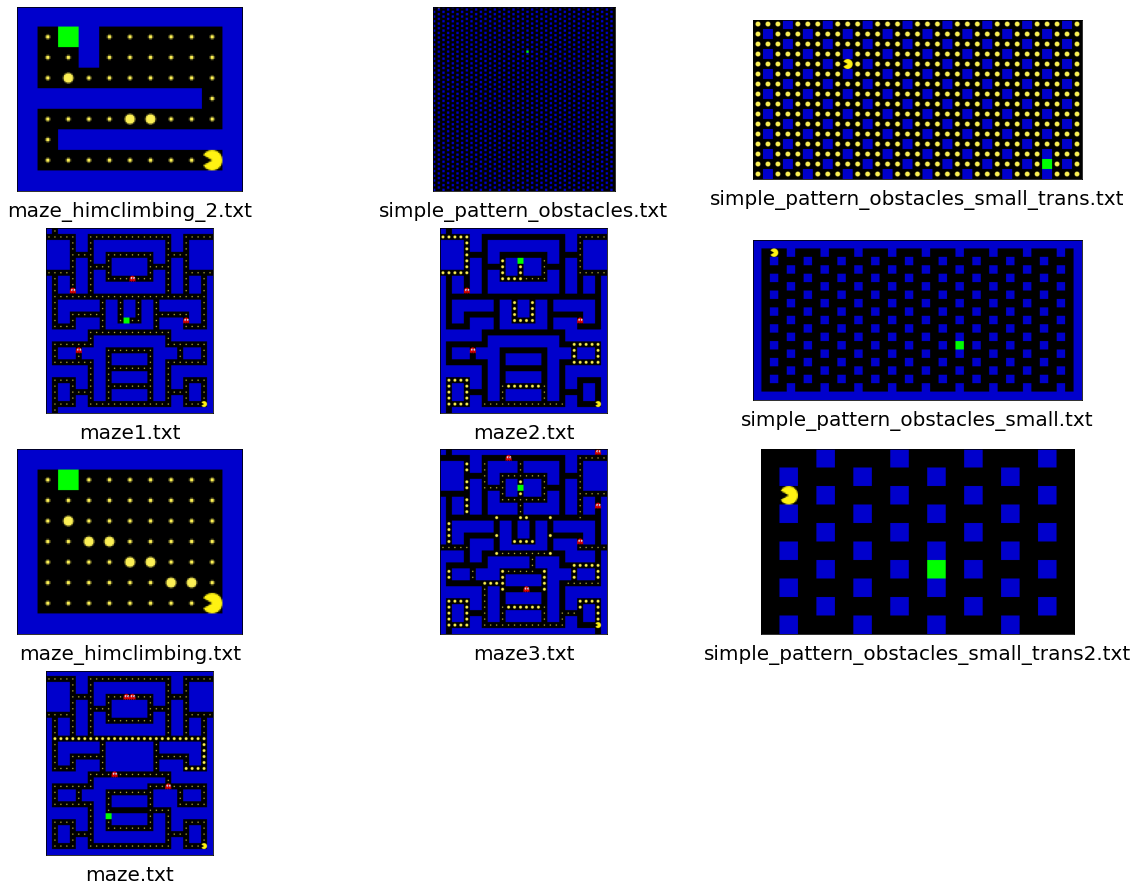

In [188]:
plot_mazes_images([])

# BFS e DFS

In [189]:
def depth_first_search(problem):
    statistics = Statistics()

    frontier = [(Node(problem.initial))]

    explored = set()
    while frontier:
        statistics.update_memory(len(frontier))
        statistics.update_iterations(1)
        node = frontier.pop()
        if problem.goal_test(node.state):
            statistics.finish(node.path_cost)
            return statistics, node
        explored.add(node.state)
        childs = [child for child in node.expand(problem)
                  if child.state not in explored and child not in frontier]
        frontier.extend(childs)
        statistics.update_expanded(len(childs))

    statistics.finish(node.path_cost)
    return statistics, None


def breadth_first_search(problem):
    statistics = Statistics()
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = deque([node])
    explored = set()
    while frontier:
        statistics.update_memory(len(frontier))
        statistics.update_iterations(1)
        node = frontier.popleft()
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    statistics.finish(child.path_cost)
                    return statistics, child
                frontier.append(child)
                statistics.update_expanded(1)
    statistics.finish(node.path_cost)
    return statistics, None

### maze1.txt

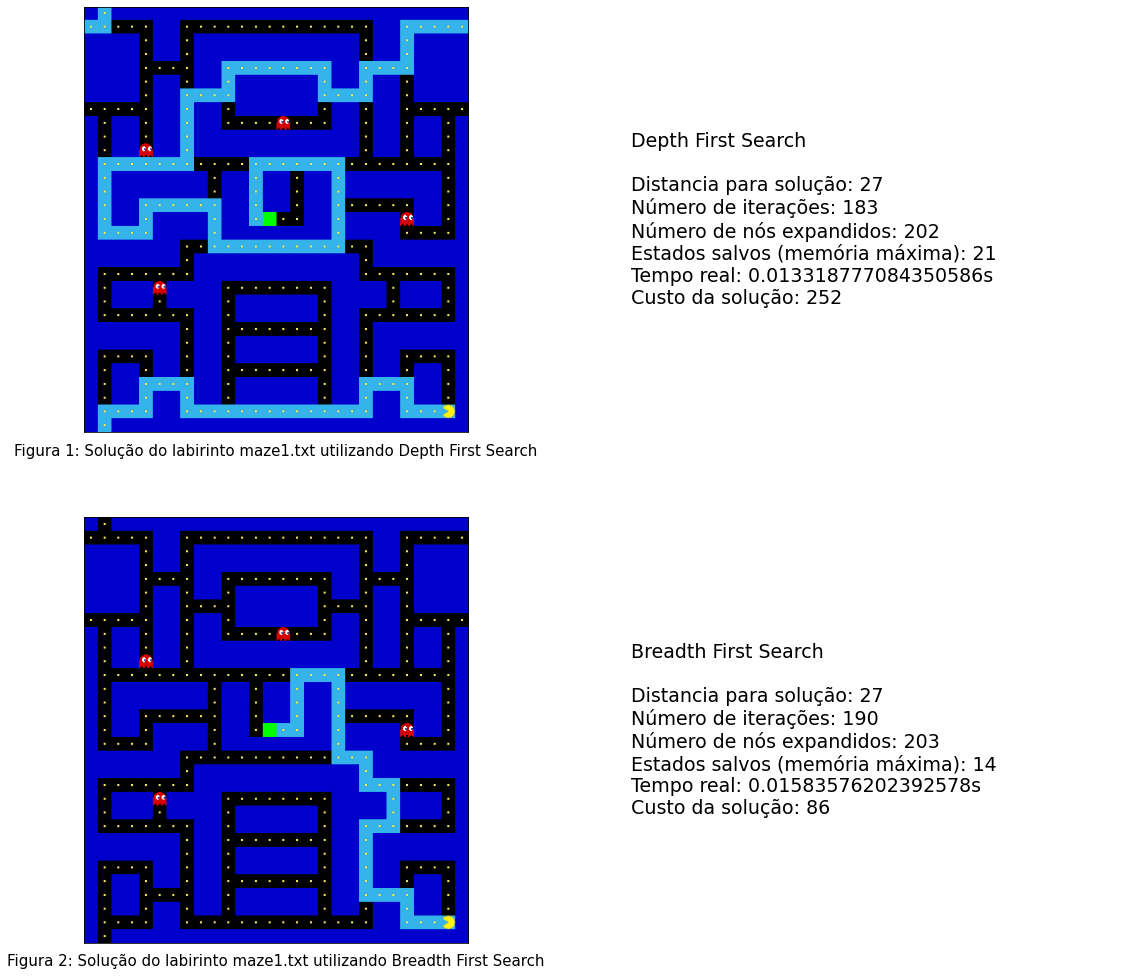

In [14]:
analysis_mazes(['maze1.txt'], 
               [[depth_first_search, 'Depth First Search'], [breadth_first_search, 'Breadth First Search']])

Neste exemplo do **maze1.txt** observa-se como ambos algoritmos, *Depth First Search* e *Breadth First Search* conseguem encontrar uma solução devido às suas propriedades de **completude**, entretanto ao contrário do **DFS**, o **BFS** para esse labirinto em específico encontrou uma **solução ótima** com custo 86, bem discrepante em relação ao **DFS** que encontrou caminho com custo 252. 

Como o **DFS** expande os nós na ordem cima, direita, baixo, esquerda, para colocar na pilha, há uma prioridade do caminho escolhido priorizar os movimentos esquerda, baixo, direita e cima, nessa ordem, isso explica o caminho escolhido pelo algoritmo neste exemplo.

Observa-se também que tanto o **BFS** como o **DFS** tiveram coincidemente quase o mesmo número de iterações. Quanto ao consumo de memória, notamos que o **BFS** consumiu menos memória do que o **DFS** - o que não foi um caso isolado desse exemplo mas é explicado devido a própria natureza do problema: cada estado na média tem poucos filhos  possíveis (no máximo 4), e como consideramos que o pacman não pode passar pela mesma posição, o espaço de busca reduz drasticamente visto que há muitas instersecções dos possíveis caminhos no labirinto, o que faz com o que o **BFS** descarte nós da pilha rapidamente enquanto o **DFS** como ele tende a "ir mais fundo", ele acaba tendo que empilhar vários estados ao longo desse caminho "mais longo" que ele acaba encontrando, por isso o consumo de memória ficou maior nesse algoritmo em relação ao **BFS**. 

Vale ressaltar que o **BFS** nesse exemplo é **ótimo**, pois **qualquer movimento do pacman tem o mesmo custo** -  todo mapa esta preenchido por *coin*, o qual atribuímos custo 2. Na pŕoxima célula teremos um exemplo onde o **BFS não é ótimo**.

### maze2.txt

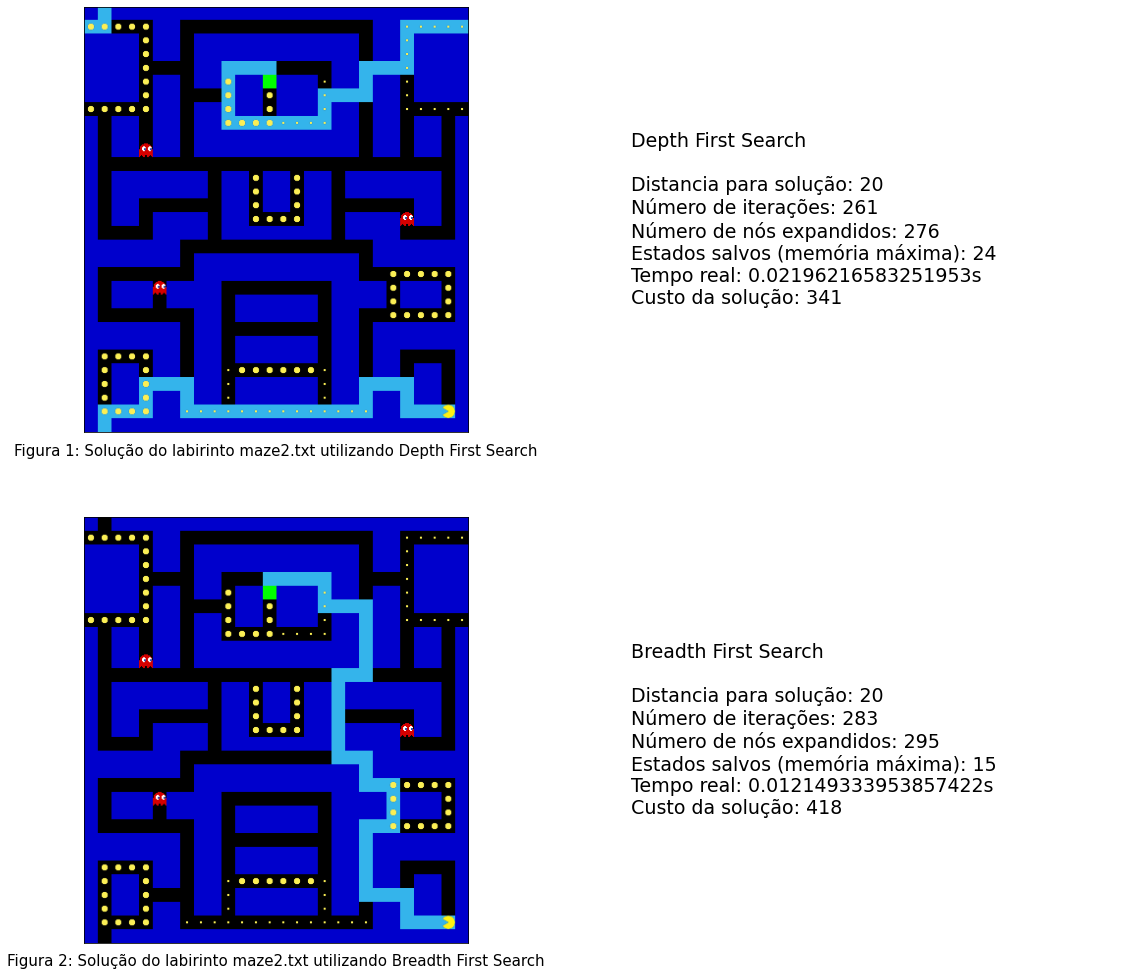

In [15]:
analysis_mazes(['maze2.txt'], 
               [[depth_first_search, 'Depth First Search'], [breadth_first_search, 'Breadth First Search']])

Neste exemplo do **maze2.txt**, observamos que o **BFS não encontrou solução ótima** (seria apenas com custo iguais para qualquer transição), pois existe um caminho com menor custo ao encontrado que evita o alto custo de espaço livre (10), inclusive neste exemplo o **DFS**, "por sorte", acabou encontrando um caminho melhor que o **BFS**, apesar de ainda não ser ótimo neste cenário. Caminhos ótimos, em que transições de estados que possuem custos diferentes podem ser encontrados utilizando o algoritmo *Uniform Cost Search*.

# Uniform cost search

In [16]:
def _best_first_search(problem, f, display=False):
    statistics = Statistics()
    f = memoize(f, 'f')
    node = Node(problem.initial)
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    explored = set()

    while frontier:
        statistics.update_memory(len(frontier))
        statistics.update_iterations(1)
        node = frontier.pop()
        if problem.goal_test(node.state):
            statistics.finish(node.path_cost)
            if display:
                print(len(explored), "paths have been expanded and", len(frontier), "paths remain in the frontier")
            return statistics, node
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                statistics.update_expanded(1)
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)
                    statistics.update_expanded(1)
    statistics.finish(node.path_cost)
    return statistics, None

def uniform_cost_search(problem, display=False):
    return _best_first_search(problem, lambda node: node.path_cost, display)

### maze2.txt

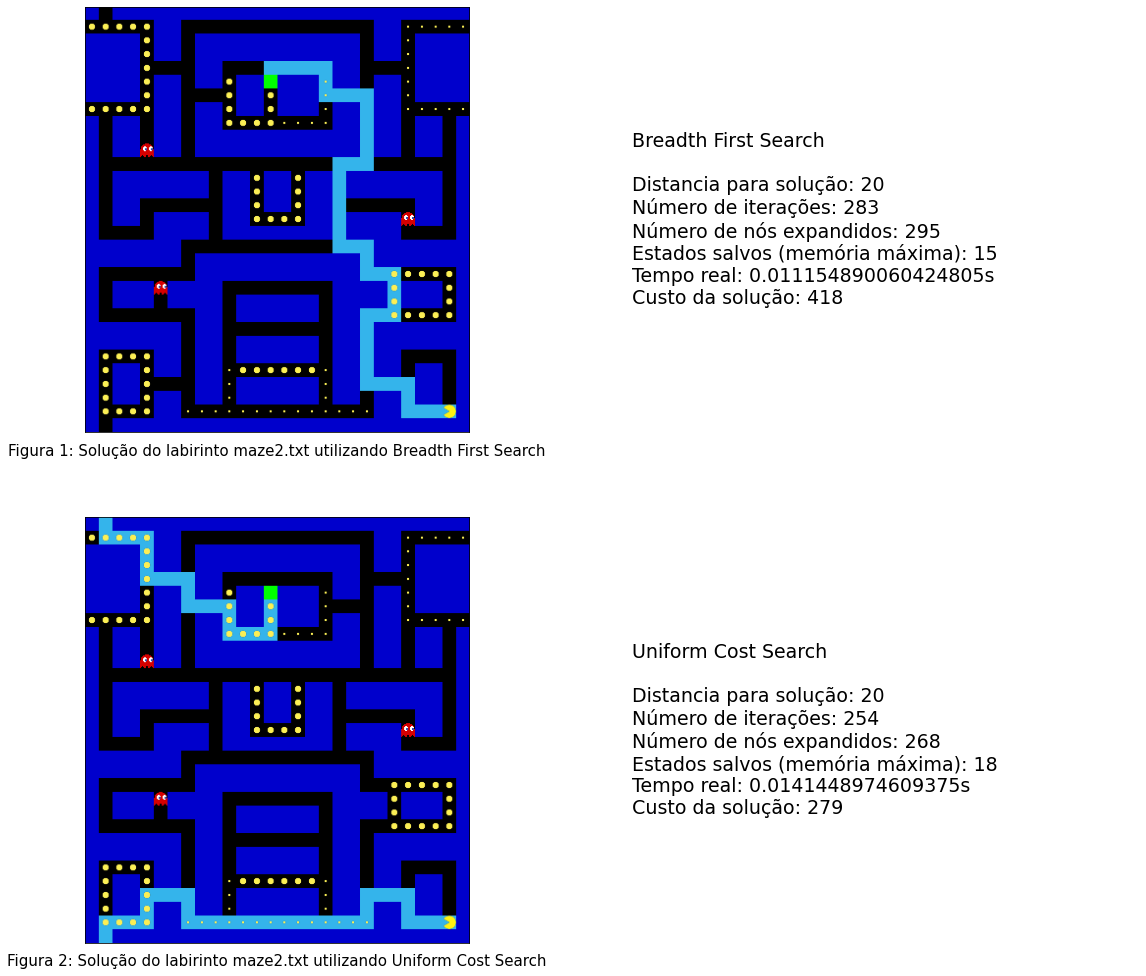

In [17]:
analysis_mazes(['maze2.txt'], 
               [[breadth_first_search, 'Breadth First Search'],
                [uniform_cost_search, 'Uniform Cost Search']])

Observa-se que agora que o *Uniform Cost Search* encontrou uma solução melhor do que o **BFS** para o problema do **maze2.txt** e é ótima com custo 279 e ainda com menos iterações (254 contra 283).

Mas será que conseguiremos reduzir o custo computacional (número de iterações) destes algoritmos indroduzindo heuristicas?

# Heurísticas

In [18]:
def ldistance_trans(pos, maze, l=1):
    '''
    Distancia l (l=1 manhattan, l=2 euclidean) considerando regioes transversaveis
    '''
    
    distances = []
    for goal in maze.goal_states:
        x_distance = min(abs(goal[0]-pos[0]), abs(goal[0]-(pos[0]+maze.w)), abs(goal[0]-(pos[0]-maze.w)))
        y_distance = min(abs(goal[1]-pos[1]), abs(goal[1]-(pos[1]+maze.h)), abs(goal[1]-(pos[1]-maze.h)))
        distances.append(((x_distance**l)+(y_distance**l))**(1./l))
        
    return min(distances)

def ldistance(pos, maze, l=1):
    '''
    Distancia l (l=1 manhattan, l=2 euclidean) sem considerar regioes transversaveis
    '''
    
    distances = []
    for goal in maze.goal_states:
        x_distance = abs(goal[0]-pos[0])
        y_distance = abs(goal[1]-pos[1])
        distances.append(((x_distance**l)+(y_distance**l))**(1./l))
        
    return min(distances)


def h_manhattan_distance_trans(pos, maze):
    return ldistance_trans(pos, maze, 1)

def h_manhattan_distance(pos, maze):
    return ldistance(pos, maze, 1)

def h_euclidean_distance_trans(pos, maze):
    return ldistance_trans(pos, maze, 2)

def h_euclidean_distance(pos, maze):
    return ldistance(pos, maze, 2)

def h_number_of_obstacles(pos, maze):
    '''Essa heuristica conta o numero de obstaculos entre o nó atual e o nó objetivo,
    supõe-se que quanto menos obstaculo, melhor será'''
    
    distances = []
    for goal in maze.goal_states:
        total = 0
        # seleciona todas as linhas do labirinto entre as posições do nó e do objetivo
        if goal[1] < pos[1]:
            sub_maze_lines = maze._maze[goal[1]:pos[1]]
        else:
            sub_maze_lines = maze._maze[pos[1]:goal[1]]

        # para cada linha verifica entre as colunas do nó e do objetivo, quantos obstaculos existem
        for line in sub_maze_lines:
            if goal[0] < pos[0]:
                sub_maze_columns = line[goal[0]:pos[0]]
            else:
                sub_maze_columns = line[pos[0]:goal[0]]
            total += sub_maze_columns.count(PosType.GHOST.value)
            total += sub_maze_columns.count(PosType.WALL.value)
        distances.append(total)
    return min(distances)

# Best first search

In [19]:
def best_first_search(problem, heuristic_function, display=False):
    return _best_first_search(problem, lambda node: heuristic_function(node.state, problem.maze), display)

A heurística mais comum de se pensar para resolver este problema é sempre escolher a posição que me deixa mais próximo para chegar no objetivo, uma vez que quanto mais próximo, menos passos o pacman terá que dar para concluir e portanto, menor será o custo total - isso pode ser feito medindo a distância do estado atual para o objetivo. Resolvemos comparar a distância euclidiana e de manhattan aplicados ao algoritmo *Best First Search*.

### maze2.txt

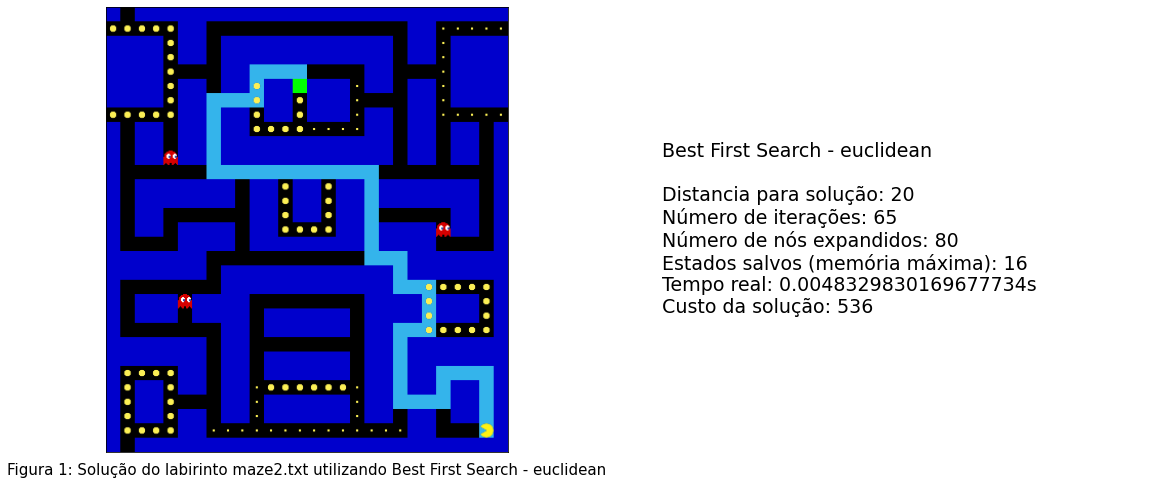

In [20]:
analysis_mazes(['maze2.txt'], 
               [[best_first_search, 'Best First Search - euclidean', h_euclidean_distance]])

Como esperado, o *Best First Search* com a **heurística de distância euclidiana** para o problema **não apresentou solução ótima** como *Uniformed Cost Search*, em contrapartida, este método apresentou consideravelmente um menor de iterações em relação ao aos métodos anteriores. Entretanto, propositalmente, há um erro nessa heurística em não considerar que o mapa pode ser transversável (funcionaria melhor para labirintos que não possui essas regiões). Ao corrigir o calculo dessa heuristica:

### maze2.txt

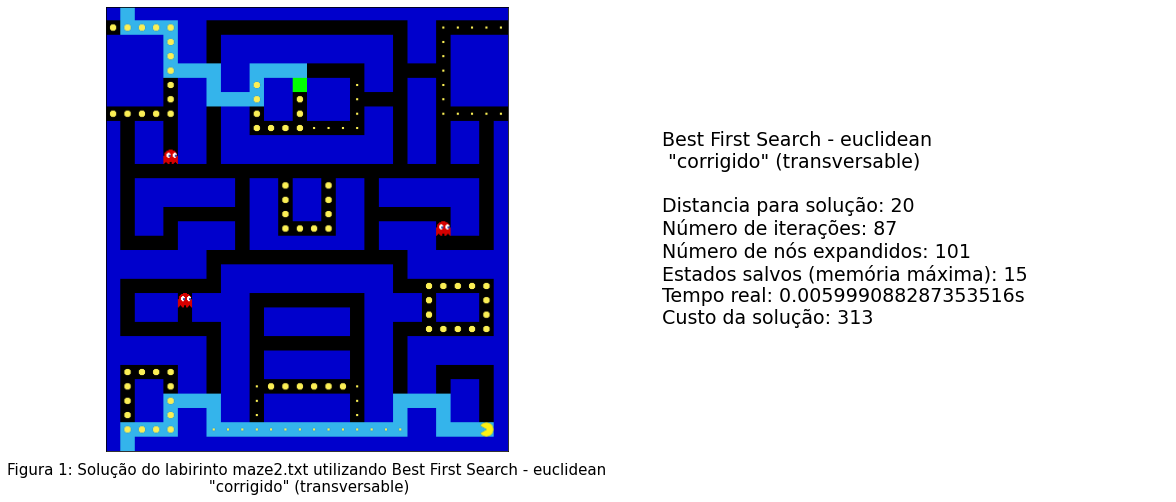

In [21]:
analysis_mazes(['maze2.txt'], 
               [[best_first_search, 'Best First Search - euclidean\n "corrigido" (transversable)', 
                 h_euclidean_distance_trans]])

Observamos que agora com a heurística corrigida, o *Best First Search* com a **heurística de distância euclidiana** encontrou uma solução melhor (313), apesar de ainda não ser ótima igual ao *Uniformed Cost Search* (279), porém conforme já observado com menor numero de iterações.

Comparando com distancia de manhattan:

### maze2.txt

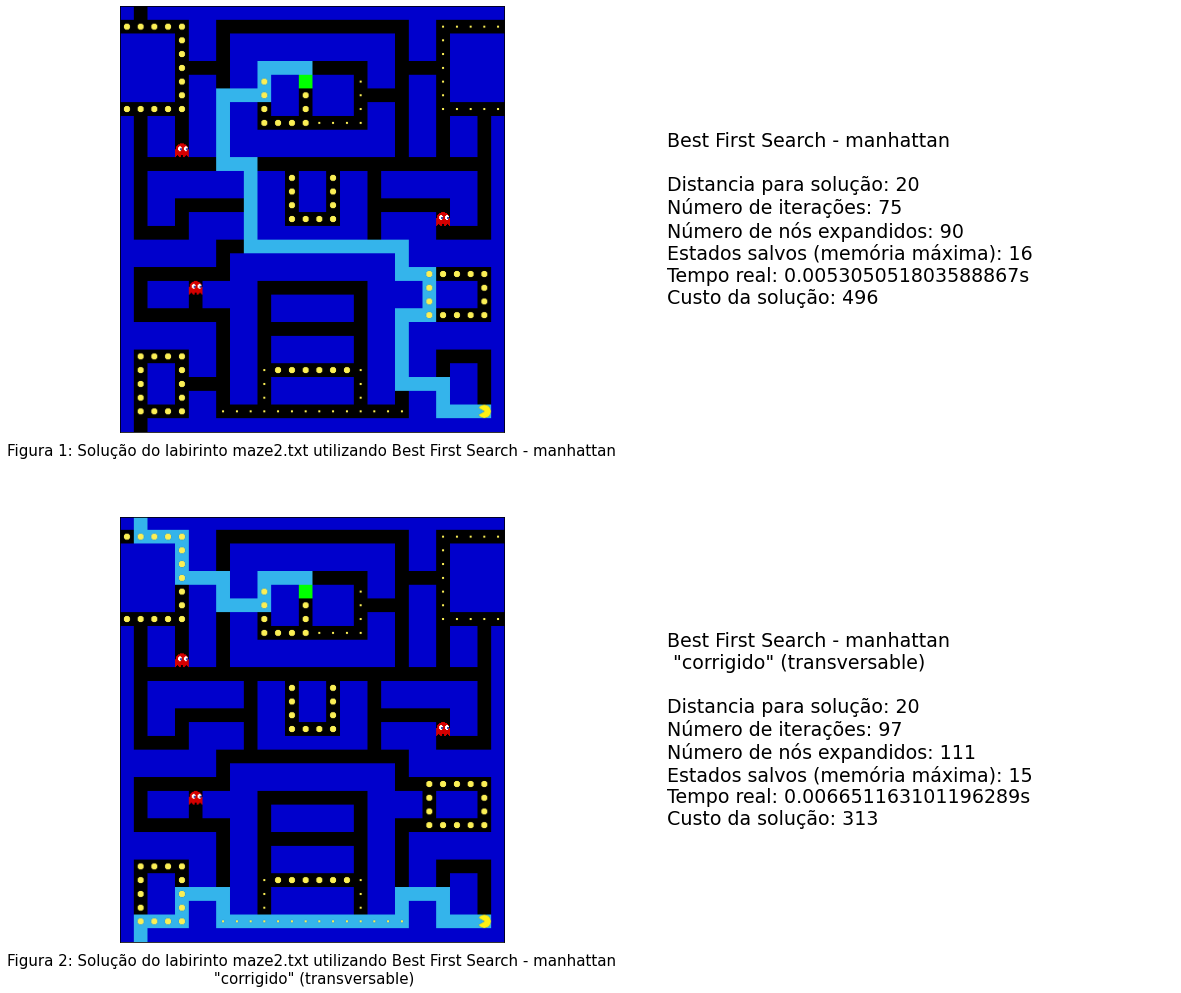

In [22]:
analysis_mazes(['maze2.txt'], 
               [[best_first_search, 'Best First Search - manhattan', h_manhattan_distance],
                [best_first_search, 'Best First Search - manhattan\n "corrigido" (transversable)', h_manhattan_distance_trans]])

Observa-se que a distancia de manhattan levaram as mesmas soluções que a euclidiana. É possível notar levemente um número maior de iterações com a **distância de manhattan**. Apesar desse experimento ser inconclusivo, suspeitavamos que heurística de manhattan levasse à um algoritmo melhor pelo fato do pacman não se mover pelas diagonais - essa heurística é mais realista em relação ao menor caminho que pode existir a partir de uma posição.

Entretanto, algo que pode ser observado é que a distância euclidiana é boa para "desempate" do melhor caminho que o pacman deve escolher, por exemplo, se o pacman esta na posição **(xp, yp)** e o objetivo estiver na **(xg, yg)**, considerando **xp!=xg** e **yp!=yg** mesmo que o pacman tenha 4 opções de células destino, apenas duas delas próximas do objetivo terão o mesmo custo de manhattan, o que acontece na maioria dos caso. Já a distância euclidiana, nesse cenário, terá o menor custo através do movimento no eixo que estiver mais distante, a não ser que a distancias nos eixos forem iguais, não tendo um desempate.

O resultado é que a distancia de manhattan vai privilegiar a ordem dos movimentos definidos pelo algoritmo (visto que as posições candidatas possuem o mesmo custo), enquanto a distancia euclidiana vai privilegiar células que levam a um caminho mais diagonalizado. Como pode ser visto na execução abaixo:

### simple_pattern_obstacles_small.txt

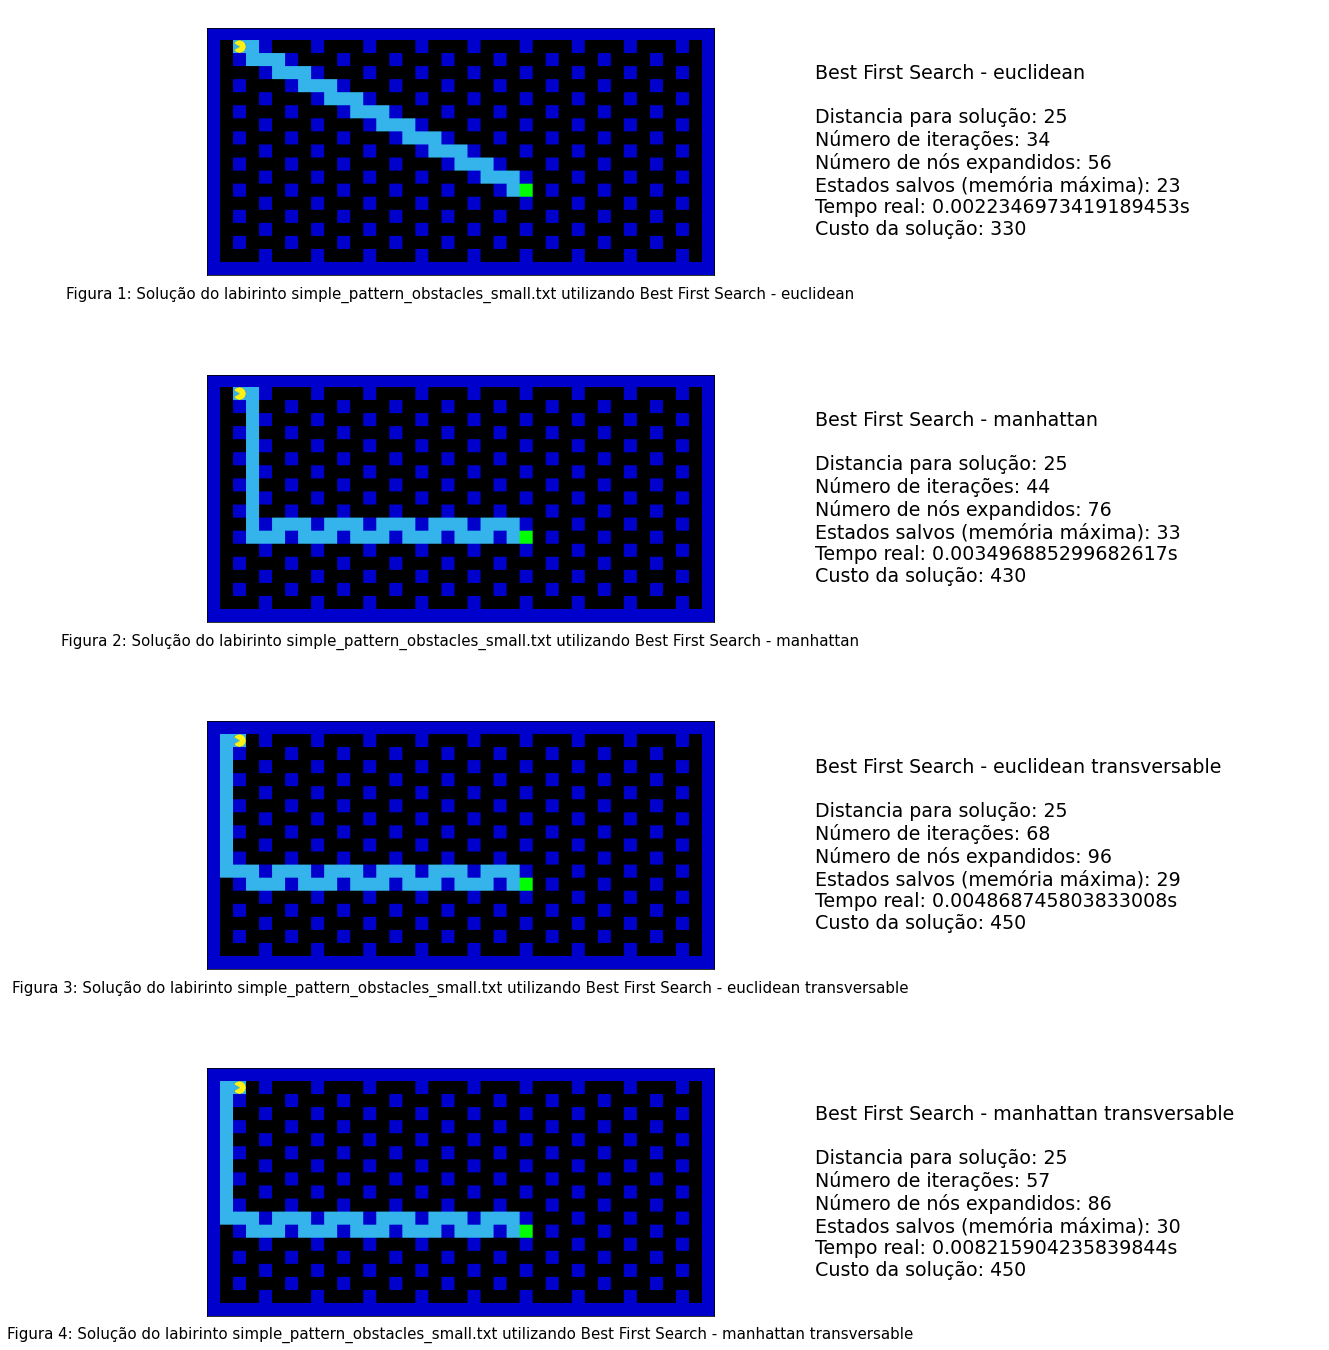

In [23]:
analysis_mazes(['simple_pattern_obstacles_small.txt'], 
               [[best_first_search, 'Best First Search - euclidean', h_euclidean_distance],
                [best_first_search, 'Best First Search - manhattan', h_manhattan_distance],
                [best_first_search, 'Best First Search - euclidean transversable', h_euclidean_distance_trans],
                [best_first_search, 'Best First Search - manhattan transversable', h_manhattan_distance_trans]], 
               figsize=(20, 50))

Esse mapa **simple_pattern_obstacles_small.txt** é interessante para observar o efeito de considerar a heuristíca transversável ou não. Pode-se notar que como o mapa não é transversavel em nenhuma parte e a distancia do PACMAN para o objetivo seria menor se o pacman pudesse atravessar o mapa para chegar do outro lado, ele tende a escolher posições que leva a travessia do mapa, o que acaba levando a uma solução com custo maior.

Ao utilizar a heurística mais adequada podemos ver que a distancia **euclidiana** acabou encontrando uma solução melhor do que a **manhattan**, pelo fator de "desempate" - de sempre aproximar pelo eixo que esta mais longe da solução - o que "por sorte" acabou levando à uma solução melhor que por sinal é ótima também.

# A* search
Essa é a forma de 'best-first search' mais conhecida e utilizada, ela combina as funções *g(n)* (custo para alcançar o nó desde a origem) e *h(n)* (uma heurística que estima o menor custo do nó até a meta), ou seja, *f(n) = g(n) + h(n)*. \
Esse algoritmo deve ser completo (encontrar uma solução) e ótimo. Para ser ótimo a heurística *h(n)* escolhida deve satisfazer 2 condições:\
**1- Ser admissível:** nunca sobrestimar o custo para atingir o objetivo. Ao combinar *g(n)* garantimos que no pior caso a solução do problema é custo para alcançar o objetivo desde a origem, portanto a heurística escolhida deverá sempre ser otimista e tentar encontrar uma solução que seja mais rápida \
**2- Ser consistente:** Se para cada nó *n* e para cada sucessor *n'* de *n* gerado por uma ação *a*, o custo estimado para alcançar *n* não é maior que o custo para alcançar *n'* mais o custo estimado para alncaçar o objetivo a partir de *n'*, essa é uma forma geral da desigualdade de triângulo *h(n) <= c(n, a, n') + h(n')*

Vamos propor 3 heurísticas para a solução do problema, para cada uma delas verificamos se as 2 condições são satisfeitas e portanto se a heurística proposta é válida. Definindo os pontos A=(xa,ya) como o posição atual do pacman no labirinto e T=(xt, yt) como a posição objetivo. As heurísticas são as seguintes: \
**1- Distância de manhattan:** calculamos a distância da posição atual com a meta nos eixos x e y e somamos considerando o mapa como transversável por todos os lados. A menor distância supomos ser a que nos levara mais rápida a solução. \
**2- Distância euclidiana:** calculamos a distância eucliadana dos pontos A e T. Essa heurística é admissível pois a distância entre 2 pontos qualquer é sempre uma linha reta \
**3- Menor número de obstáculos:** calculamos o número de obstáculos (fantasmas e paredes) na região entre os pontos A e T, quanto menor o número de obstáculos supomos ser mais rápido de encontrar 

In [24]:
def astar_search(problem, heuristic_function, display=False):
    return _best_first_search(problem, lambda n: n.path_cost + heuristic_function(n.state, problem.maze))

In [ ]:
analysis_mazes(['maze2.txt'], 
               [[uniform_cost_search, 'Uniform cost search'],
                [astar_search, 'A* search - manhattan', h_manhattan_distance_trans],
                [astar_search, 'A* search - euclidean', h_euclidean_distance_trans],
                [astar_search, 'A* search - number of obstacles', h_number_of_obstacles]])

Observa-se que o método **A*** trouxe um custo maior em termos de iterações para encontrar a solução em relação ao *Best First Search*, mas ao contrário deste, este algoritmo **A*** com a **heurística admissível** é ótimo e encontrou a mesma solução ótima do *Uniform Cost Search* com uma leve redução no número de iterações, tornando-a uma heuristica razoavel para o problema

Tanto a distância de manhattan como a euclideana, são heurísticas admissíveis para o problema pois, o custo mais curto que pode haver entre dois pontos de um mapa é a distancia de manhattan (como não temos movimentos diagonais, e os custos são sempre >= 1), e como euclideana <= manhattan, ambas são otimistas e nunca superstimam o custo da melhor solução. Entretanto, deve-se ter cuidado com os casos transaversaveis:

In [ ]:
analysis_mazes(['simple_pattern_obstacles_small_trans.txt'], 
               [[astar_search, 'Best First Search - euclidean', h_euclidean_distance],
                [astar_search, 'Best First Search - manhattan', h_manhattan_distance]],
               figsize=(20, 25), mazeargs=[1])

Acima temos exemplo da execução do **A* com heurísticas não admissíveis** pois não levam em conta que o mapa pode ser transversável. Abaixo temos a execução do **A*** com heurísticas corretamente admissíveis:

In [ ]:
analysis_mazes(['simple_pattern_obstacles_small_trans.txt'], 
               [[astar_search, 'Best First Search - euclidean transversable', h_euclidean_distance_trans],
                [astar_search, 'Best First Search - manhattan transversable', h_manhattan_distance_trans]], 
               figsize=(20, 25), mazeargs=[1])

Neste caso o custo da solução é solução encontrada é o mesmo da solução otimista dada pela heuristíca de Manhattan.

# Hill Climbing

Para facilitar a análise do hill climbing vamos adicionar algumas restrições ao problema: são mapas não transversaveis, e só é possível ter uma posição objetivo.

In [25]:
def hill_climbing(problem, display=False):
    statistics = Statistics()
    statistics.distance = manhattan_distance(problem.initial, problem.maze) 
    current = Node(problem.initial)
    images = []
    
    while True:
        statistics.update_iterations(1)
        neighbors = current.expand(problem)
        if not neighbors:
            break
        neighbor = argmin_random_tie(neighbors, key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) > problem.value(current.state):
            break
        current = neighbor
        ### Plot map
        problem.maze.initial_state = current.state
        images.append(problem.maze.get_map_image())
        ###
        statistics.update_expanded(1)
        
    statistics.finish(current.path_cost)
    
    if display:
        plot_image(*images, titles=[str(i) for i in range(1, len(images)+1)], table_format=(0, 4), figsize=(20, 15*(len(images)/4)))

    if problem.goal_test(current.state):
        return statistics, current
    return statistics, None

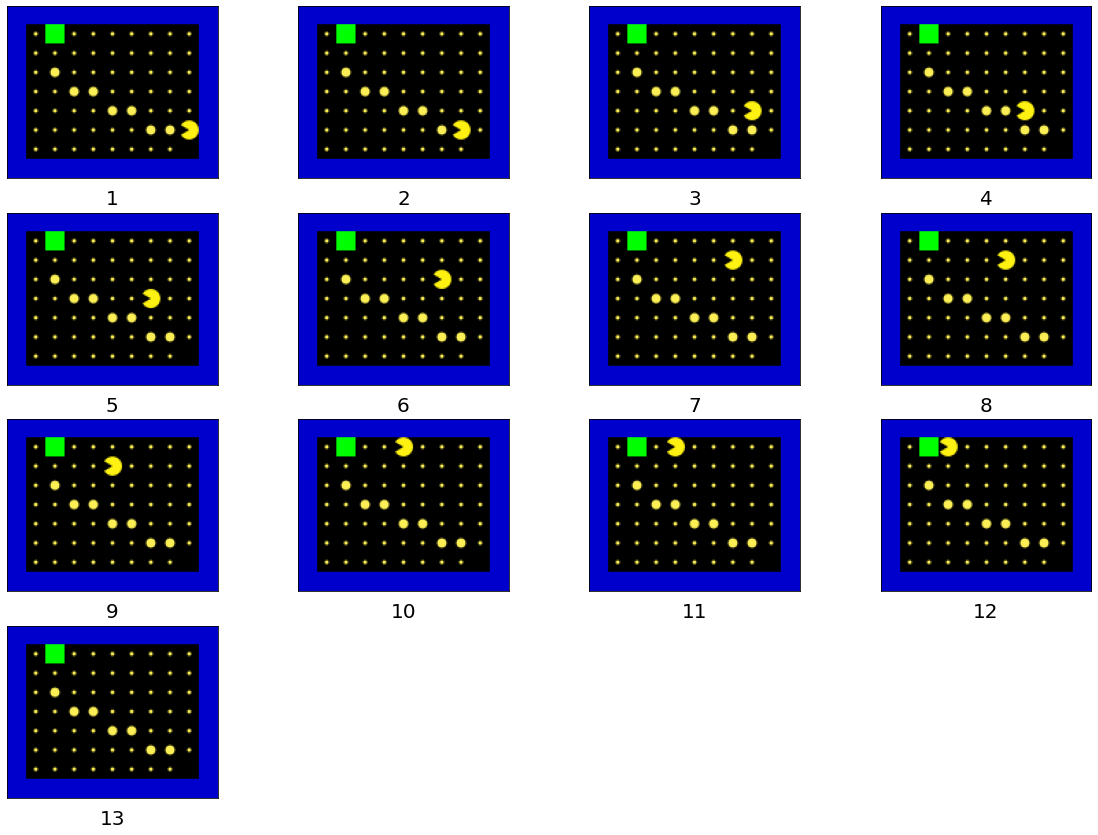

Distancia para solução: 7
Número de iterações: 14
Número de nós expandidos: 14
Estados salvos (memória máxima): 1
Tempo real: 0.0072062015533447266s
Custo da solução: 33


In [26]:
maze = Maze("mazes/maze_himclimbing.txt")
problem = MazePacmanProblem(maze)
statistics, node = hill_climbing(problem, display=True)
print(statistics)

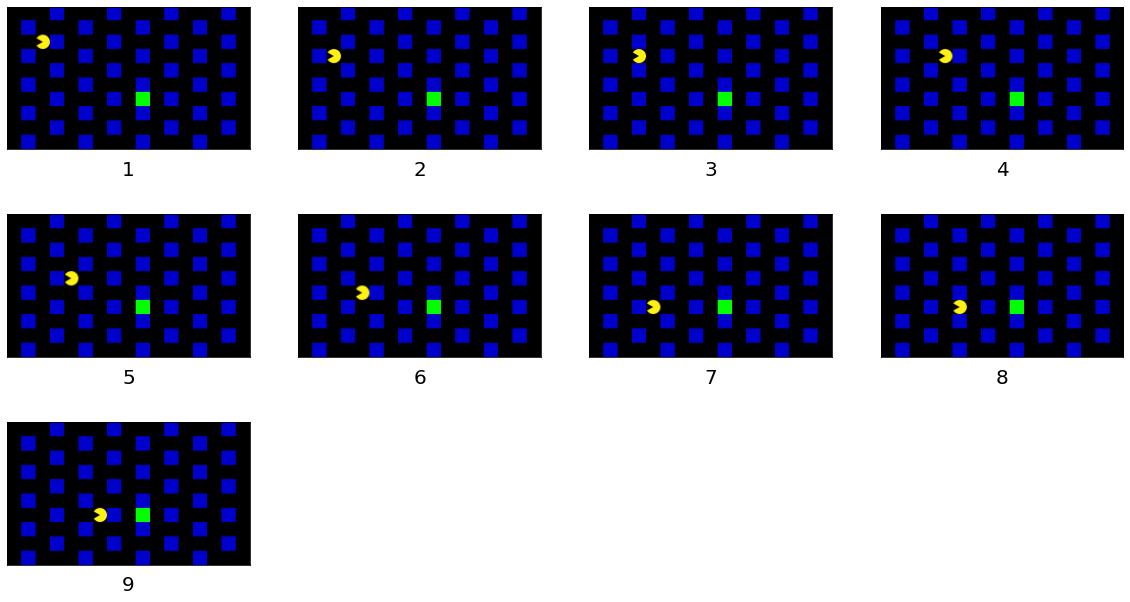

Distancia para solução: 12
Número de iterações: 10
Número de nós expandidos: 10
Estados salvos (memória máxima): 1
Tempo real: 0.009463787078857422s
Custo da solução: 90


In [27]:
maze = Maze("mazes/simple_pattern_obstacles_small_trans2.txt")
problem = MazePacmanProblem(maze)
statistics, node = hill_climbing(problem, display=True)
print(statistics)

In [ ]:
maze = Maze("mazes/simple_pattern_obstacles_small_trans.txt")
problem = MazePacmanProblem(maze)
statistics, node = hill_climbing(problem, display=True)
print(statistics)

In [ ]:
maze = Maze("mazes/maze2.txt")
problem = MazePacmanProblem(maze)
statistics, node = hill_climbing(problem, display=True)
print(statistics)

In [ ]:
maze = Maze("mazes/simple_pattern_obstacles_small.txt")
problem = MazePacmanProblem(maze)
statistics, node = hill_climbing(problem, display=True)
print(statistics)

Observa-se que o Hill Climbing na maior parte dos experimentos executados ele não conseguiu atingir o objetivo final.
Podemos perceber que por conta da heurística adotada para o cálculo da proximidade do objetivo, neste caso o cálculo da distância de manhattan,
no momento em que foi necessário avaliar opções de caminho para desviar de obstáculos o algoritmo entra em um estado de “mínimo local”, uma vez que para tomar a ação de desvio é necessário se afastar do objetivo final. Os casos em que foi possível atingir o objetivo foram os que em nenhum momento do percurso foi necessário se afastar do objetivo final.
Com isso, fica claro a limitação da implementação clássica do algoritmo de Hill Climbing para o alcance do objetivo final, mesmo usando uma heurística que é adequada para em algoritmos. Para alcançarmos um melhor melhor desempenho do Hill Climbing, em questão de alcance do resultado, podemos considerar heurísticas parametrizadas, que dependendo da situação poderíamos escolher entre minimizar (ou maximizar) o resultado da avaliação de formas diferentes para ter outras comparações ao chegar em um estado de mínimos local. Outra opção para sairmos do estado de “mínimo local” seria utilizar o algoritmo “Forced Hill Climbing” que permitira que saíssemos do estado atual em busca de um estado melhor usando BFS.

No resultados analisados, pudemos observar algumas boas característica do Hill Climbing. Como é o caso da quantidade de nós expandidos e o uso de memória.
Vimos que o número de nós visitados cresce linearmente com o número de iterações, o que otimiza o custo computacional usado para encontrá-la.
O uso da memória do algoritmo Hill Climbing se mostrou ótimo, ele se mantém constante independente do tamanho do mapa ou do número de nós expandidos, visto que não há armazenamentos de estados anteriores.

# Análise exaustiva

In [ ]:
solver_function_list =  [[depth_first_search, 'Depth First Search'], 
                [breadth_first_search, 'Breadth First Search'], 
                [uniform_cost_search, 'Uniform Cost Search'],
                [best_first_search, 'Best First Search - euclidean', h_euclidean_distance_trans],
                [best_first_search, 'Best First Search - manhattan', h_manhattan_distance_trans],
                [astar_search, 'A* search - manhattan', h_manhattan_distance_trans],
                [astar_search, 'A* search - euclidean', h_euclidean_distance_trans]]

Abaixo temos um exemplo de execução de todos agoritmos para único mapa (maze3.txt):

In [ ]:
analysis_mazes(['maze3.txt'], solver_function_list)

Utilizando esse mapa (maze3.txt) e variando as posições objetivos de forma aleatória (100 exemplos), esperamos tirar alguma conclusão estatistica:

In [ ]:
dfs = []
for solver_function in solver_function_list:
    algorithm_name = solver_function[1]
    df = random_analysis(Maze("mazes/maze3.txt"), 100, [solver_function[0], *solver_function[2:]])
    df['algorithm'] = df.shape[0] * [algorithm_name]
    dfs.append(df)
    
df = pd.concat(dfs, axis=0)
df.groupby('algorithm').agg([np.mean])

Conforme ja discutido os algoritmos completos para o problema em ordem de maior eficiencia para menor foram: **A* search - manhattan**, **A* search - euclidean** e **Uniform Cost Search**.

E para esse exemplo, a heuristíca manhattan aparenta leva uma pequena vantagem em relação à euclidiana em número de iterações para os dois algoritmos: **A*** e *Best First Search*.

Variando as posições obetivos de forma aleatória (100 exemplos) no mapa simple_pattern_obstacles.txt:

In [ ]:
plot_image(Maze("mazes/simple_pattern_obstacles.txt").get_map_image(), figsize=(10,5))

In [ ]:
dfs = []
for solver_function in solver_function_list:
    algorithm_name = solver_function[1]
    df = random_analysis(Maze("mazes/simple_pattern_obstacles.txt"), 100, [solver_function[0], *solver_function[2:]])
    df['algorithm'] = df.shape[0] * [algorithm_name]
    dfs.append(df)

df = pd.concat(dfs, axis=0)
df.groupby('algorithm').agg([np.mean])

Nesta tabela acima, notamos que a ordem se mantém para os melhores algoritmos completos e que o *Best First Search - euclidean* foi ótimo em todas as soluções, isso se deve a caracteristíca desse mapa de ser vazado e sempre ser possível relizar um movimento em direção ao objetivo.

É possível perceber que a diferença entre *Uniform Cost Search* e **A*** ainda é bem estreita. De fato, a heuristíca ajuda resolver o problema, mas o fato de termos posiçṍes com custo 10 (o que é relativamente maior que 1) faz com que essas heurísticas sejam otimistas demais para o problema. É possível perceber o outro extremo na tabela abaixo, onde trocamos o custo dos espaço livre para 1:

In [ ]:
dfs = []
for solver_function in solver_function_list:
    algorithm_name = solver_function[1]
    df = random_analysis(Maze("mazes/simple_pattern_obstacles.txt", free_cost=1), 100, [solver_function[0], *solver_function[2:]])
    df['algorithm'] = df.shape[0] * [algorithm_name]
    dfs.append(df)

df = pd.concat(dfs, axis=0)
df.groupby('algorithm').agg([np.mean])

Com essa modificação, e como o mapa só possui paredes ou posições livres é possível notar um melhor desempenho do **A***. Portanto, um fator crucial para o melhor desempenho do **A*** é a escolha da função heuristíca que deve ser otimista mas no limiar de ser pessimista.

#### Análise BFS, DFS, A* ... em gráficos para diferentes posições aleatórias

### Comportamento dos algoritmos
Nesta seção analisamos como cada um dos algorítmos se comporta em relação a distância entre o pacman e o objetivo. Rodamos os algoritmos com 100 posições de objetivo em mapas distintos, considerando cálculos de distância euclidiana e manhattan, transversável ou não.

### Mapa com obstáculos simples, não transversável (Distância euclidiana x Iterações)
Neste caso, queremos analisar o custo computacional de cada algorítmo considerando a distância entre o pacman e objetivo.

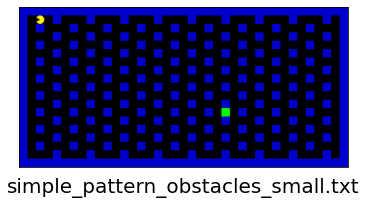

In [28]:
plot_mazes_images(['simple_pattern_obstacles_small.txt'])

#### BFS (Distância euclidiana x Iterações)

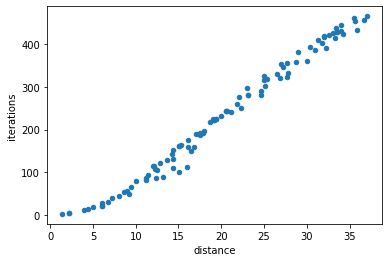

In [29]:
plot_graph(['simple_pattern_obstacles_small.txt'], [breadth_first_search], h_euclidean_distance, y='iterations', kind='scatter')

#### DFS (Distância euclidiana x Iterações)

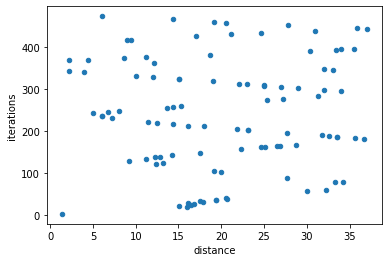

In [30]:
plot_graph(['simple_pattern_obstacles_small.txt'], [depth_first_search], h_euclidean_distance, y='iterations', kind='scatter')

#### Uniform Cost Search (Distância euclidiana x Iterações)

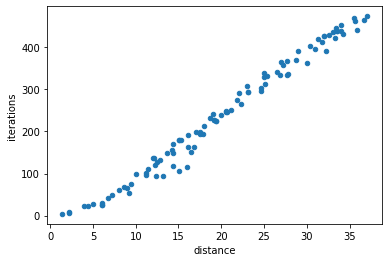

In [45]:
plot_graph(['simple_pattern_obstacles_small.txt'], [uniform_cost_search], h_euclidean_distance, y='iterations', kind='scatter')

#### A* (Distância euclidiana x Iterações)

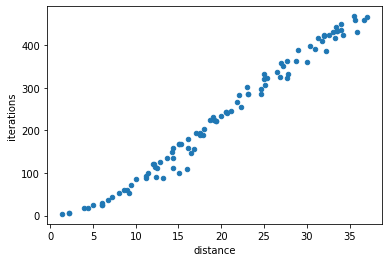

In [32]:
plot_graph(['simple_pattern_obstacles_small.txt'], [astar_search, h_euclidean_distance], h_euclidean_distance, y='iterations', kind='scatter')

#### Best First Search (Distância euclidiana x Iterações)

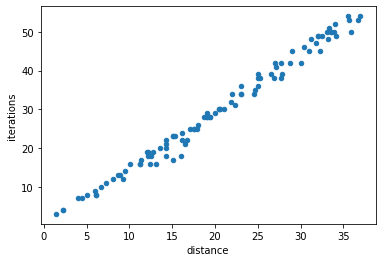

In [33]:
plot_graph(['simple_pattern_obstacles_small.txt'], [best_first_search, h_euclidean_distance], h_euclidean_distance, y='iterations', kind='scatter')

Fica claro o comportamento "imprevisível" da *Depth First Search*. Dado que esta busca se extende pela profundidade e é um algoritmo não informado, a escolha de próxima ação é arbitrária. Desta forma, o tamanho do caminho escolhido (consequentemente, o número de iterações) depende do quão convinente é a posição do objetivo.
Por outro lado, analisando *Breadth First Search*, vemos um comportamento muito semelhante ao de algortimos informados. Dado que esta cresce em largura, temos independente da posição do objetivo, uma escolha sempre de melhor caminho.

### Mapa com obstáculos simples e transversável (Distância euclidiana x Iterações)
Queremos, nos próximos exemplos, analisar o comportamento deste algorítmos, desta vez, em um mapa transversável e verificar se os comportamentos vistos acima se mantém. Em mapas traversáveis utilizamos outra função de cálculo de distância (`h_euclidean_distance_trans`).

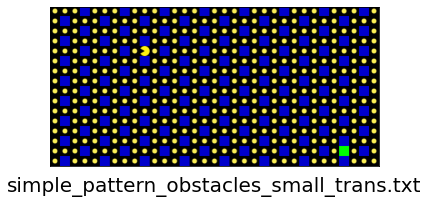

In [28]:
plot_mazes_images(['simple_pattern_obstacles_small_trans.txt'])

#### BFS (Distância euclidiana x Iterações)

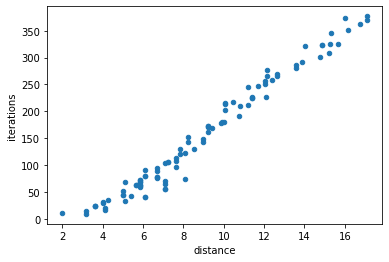

In [70]:
plot_graph(['simple_pattern_obstacles_small_trans.txt'], [breadth_first_search], h_euclidean_distance_trans, y='iterations', kind='scatter')

#### DFS (Distância euclidiana x Interações)

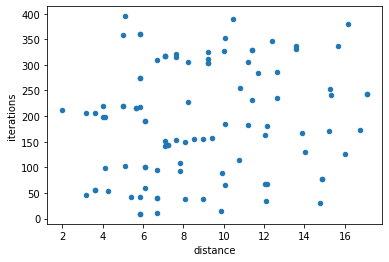

In [30]:
plot_graph(['simple_pattern_obstacles_small_trans.txt'], [depth_first_search], h_euclidean_distance_trans, y='iterations', kind='scatter')

#### Uniform Cost Search (Distância euclidiana x Iterações)

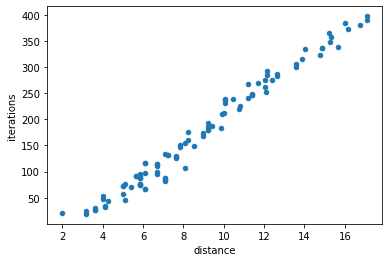

In [31]:
plot_graph(['simple_pattern_obstacles_small_trans.txt'], [uniform_cost_search], h_euclidean_distance_trans, y='iterations', kind='scatter')

#### A* (Distância euclidiana x Iterações)

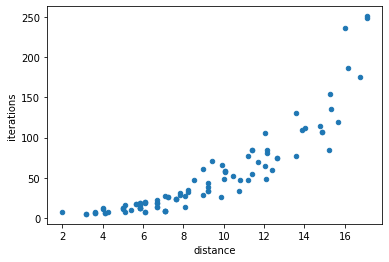

In [62]:
plot_graph(['simple_pattern_obstacles_small_trans.txt'], [astar_search, h_euclidean_distance_trans], h_euclidean_distance_trans, x='distance', y='iterations', kind='scatter')

#### Best First Search (Distância euclidiana x Iterações)

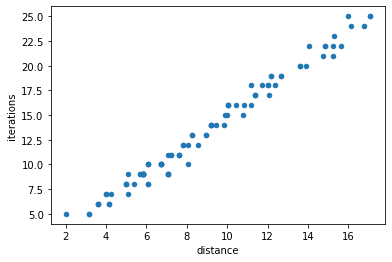

In [33]:
plot_graph(['simple_pattern_obstacles_small_trans.txt'], [best_first_search, h_euclidean_distance_trans], h_euclidean_distance_trans, y='iterations', kind='scatter')

Os gráficos acima nos mostram resultados um pouco inesperados. Neste mapa o *Breadth First Search* possui um gráfico linear, embora o esperado seria exponencial. Para ter um noção mais ampla do comportamento destes algoritmos, rodamos, com a mesma quantidade de dados (100 dados aleatórios para cada gráfico), os algoritmos em um mapa maior.

### Mapa grande com obstáculos simples e transversável (Distância euclidiana x Iterações)
Afim de compreender o comportamento dos algoritmos com distancias maiores, utilizamos um outro mapa, também transversável, entretanto maior.

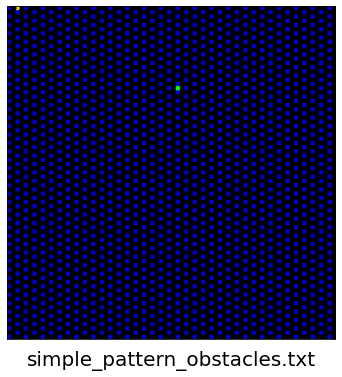

In [36]:
plot_mazes_images(['simple_pattern_obstacles.txt'])

#### BFS (Distância euclidiana x Iterações)

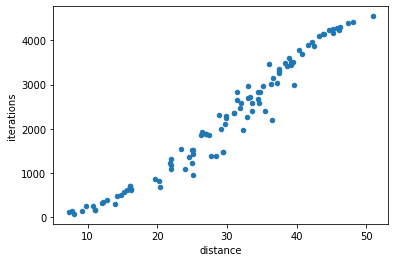

In [40]:
plot_graph(['simple_pattern_obstacles.txt'], [breadth_first_search], h_euclidean_distance_trans, y='iterations', kind='scatter')

#### DFS (Distância euclidiana x Iterações)

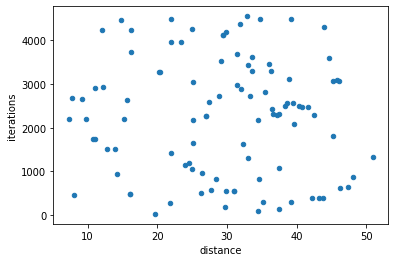

In [41]:
plot_graph(['simple_pattern_obstacles.txt'], [depth_first_search], h_euclidean_distance_trans, y='iterations', kind='scatter')

#### Uniform Cost Search (Distância euclidiana x Iterações)

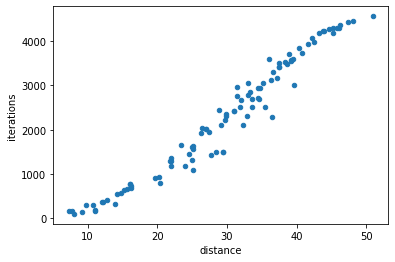

In [48]:
plot_graph(['simple_pattern_obstacles.txt'], [uniform_cost_search], h_euclidean_distance_trans, y='iterations', kind='scatter')

#### A* (Distância euclidiana x Iterações)

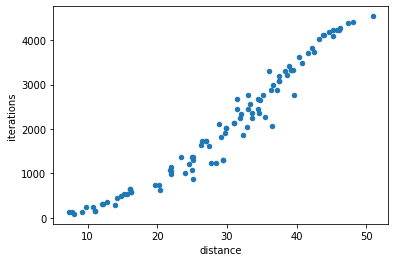

In [43]:
plot_graph(['simple_pattern_obstacles.txt'], [astar_search, h_euclidean_distance_trans], h_euclidean_distance_trans, y='iterations', kind='scatter')

#### Best First Search (Distância euclidiana x Iterações)

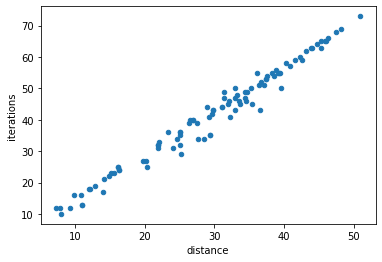

In [44]:
plot_graph(['simple_pattern_obstacles.txt'], [best_first_search, h_euclidean_distance_trans], h_euclidean_distance_trans, y='iterations', kind='scatter')

### Distância euclidiana x Distância de manhattan

O experimento acima descreve o comportamento dos algoritmos utilizando a distância euclidiana. Entretanto, é interessante analisar também o comportamento com a distância de manhattan.

#### BFS (Distância euclidiana x Iterações)

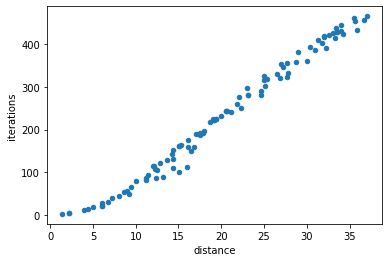

In [34]:
plot_graph(['simple_pattern_obstacles_small.txt'], [breadth_first_search], h_euclidean_distance, y='iterations', kind='scatter')

#### BFS (Distância manhattan x Iterações)

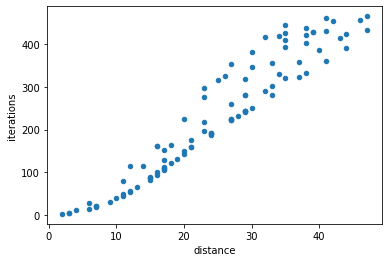

In [35]:
plot_graph(['simple_pattern_obstacles_small.txt'], [breadth_first_search], h_manhattan_distance, y='iterations', kind='scatter')

#### DFS (Distância euclidiana x Iterações)

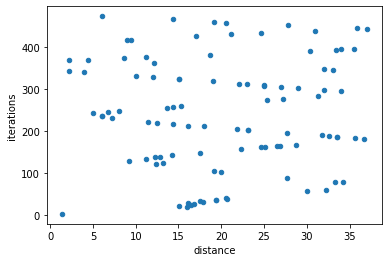

In [49]:
plot_graph(['simple_pattern_obstacles_small.txt'], [depth_first_search], h_euclidean_distance, y='iterations', kind='scatter')

#### DFS (Distância manhattan x Iterações)

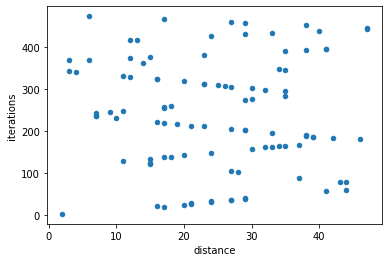

In [37]:
plot_graph(['simple_pattern_obstacles_small.txt'], [depth_first_search], h_manhattan_distance, y='iterations', kind='scatter')

#### Uniform Cost Search (Distância euclidiana x Iterações)

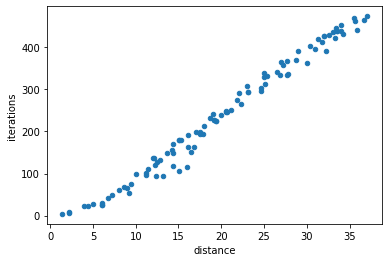

In [38]:
plot_graph(['simple_pattern_obstacles_small.txt'], [uniform_cost_search], h_euclidean_distance, y='iterations', kind='scatter')

#### Uniform Cost Search (Distância manhattan x Iterações)

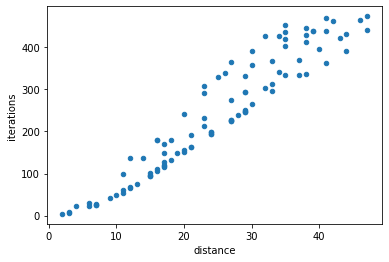

In [39]:
plot_graph(['simple_pattern_obstacles_small.txt'], [uniform_cost_search], h_manhattan_distance, y='iterations', kind='scatter')

#### A* (Distância euclidiana x Iterações)

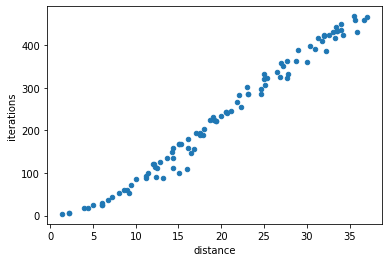

In [40]:
plot_graph(['simple_pattern_obstacles_small.txt'], [astar_search, h_euclidean_distance], h_euclidean_distance, y='iterations', kind='scatter')

#### A* (Distância manhattan x Iterações)

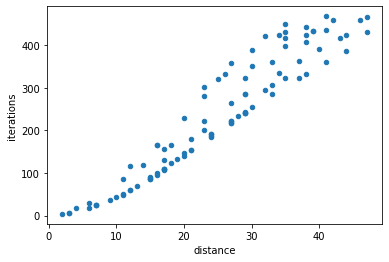

In [41]:
plot_graph(['simple_pattern_obstacles_small.txt'], [astar_search, h_manhattan_distance], h_manhattan_distance, y='iterations', kind='scatter')

#### Best First Search (Distância euclidiana x Iterações)

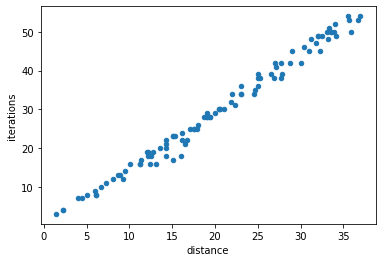

In [42]:
plot_graph(['simple_pattern_obstacles_small.txt'], [best_first_search, h_euclidean_distance], h_euclidean_distance, y='iterations', kind='scatter')

#### Best First Search (Distância manhattan x Iterações)

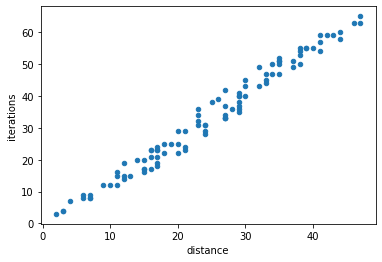

In [43]:
plot_graph(['simple_pattern_obstacles_small.txt'], [best_first_search, h_manhattan_distance], h_manhattan_distance, y='iterations', kind='scatter')

Se analizarmos os gráficos como um todo, o comportamento é bastante semelhante, tanto para distância euclidiana quanto para distância de manhattan.
Vamos analisar, então, as o comportamento para cada distância. Fica claro, que para mesmas distâncias há uma **varição em número de iterações maior na distância de manhattan** em relação a distância euclidiana. Isto é bastante visível, principalmente, nos algoritmos de *Breadth First Search*, *Uniform Cost Search* e *A**.
Para compreender esta diferenciação, precisamos esclarecer como cada distância é calculada.
A distância euclidiana é o comprimento entre a posição do Pacman e a posição do objetivo.
A distância de manhattan é a soma entre a altura e largura entre a posição do Pacman e a posição do objetivo.
Geograficamente, a diferença entre elas é a seguinte:
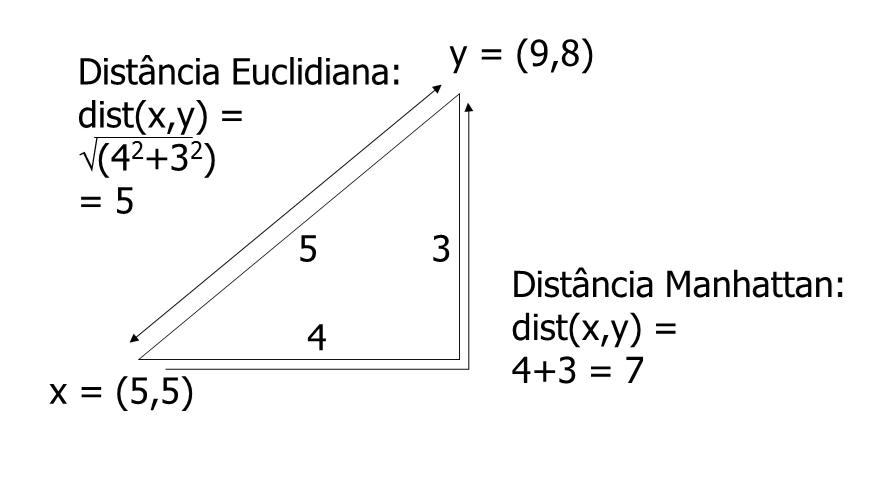
Pelo cálculo das distâncias conseguimos concluir que a distância euclidiana sofre variações menores quando as posicões se alteram, o que se reflete nos gráficos: para uma mesma distância há valores de iterações bem mais distintos para a distância de manhattan.

Figura extraída de https://mineracaodedados.wordpress.com/2012/02/27/medidas-de-distancia/

### Mapa com obstáculos simples e transversável (Iterações x Memória)
O intuito dos próximos experimentos é analisar o custo de memória relativo ao custo de processamento (iterações).

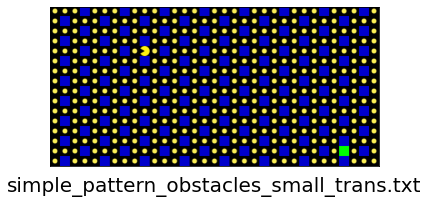

In [53]:
plot_mazes_images(['simple_pattern_obstacles_small_trans.txt'])

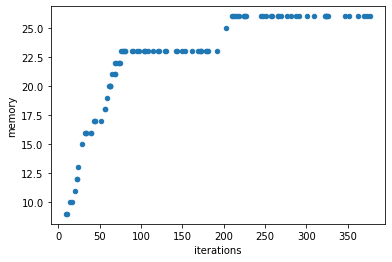

In [69]:
plot_graph(['simple_pattern_obstacles_small_trans.txt'], [breadth_first_search], h_euclidean_distance_trans, x='iterations', y='memory', kind='scatter')

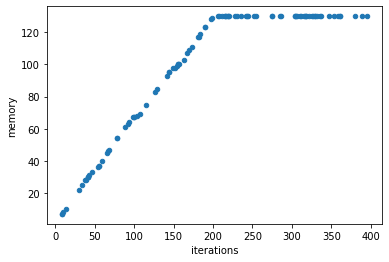

In [64]:
plot_graph(['simple_pattern_obstacles_small_trans.txt'], [depth_first_search], h_euclidean_distance_trans, x='iterations', y='memory', kind='scatter')

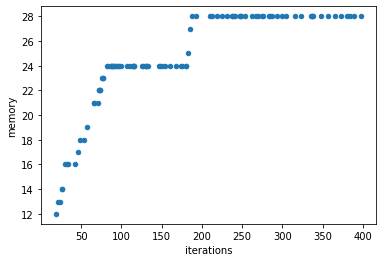

In [65]:
plot_graph(['simple_pattern_obstacles_small_trans.txt'], [uniform_cost_search], h_euclidean_distance_trans, x='iterations', y='memory', kind='scatter')

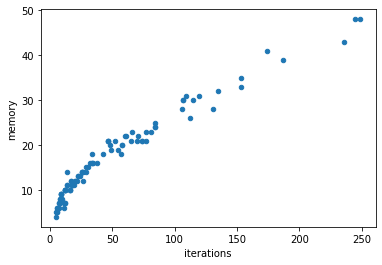

In [68]:
plot_graph(['simple_pattern_obstacles_small_trans.txt'], [astar_search, h_euclidean_distance_trans], h_euclidean_distance_trans, x='iterations', y='memory', kind='scatter')

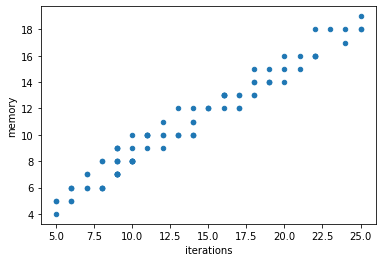

In [67]:
plot_graph(['simple_pattern_obstacles_small_trans.txt'], [best_first_search, h_euclidean_distance_trans], h_euclidean_distance_trans, x='iterations', y='memory', kind='scatter')

# Bibliografia
1. RUSSEL, S.; NORVIG, P. Artificial Intelligence:  a modern approach.  Prentice Hall.  3rd edition, 2010.
2. https://github.com/aimacode/aima-python/blob/master/search.ipynb


# Divisão das tarefas
|           | Mapas  | DFS  | BFS  | Best-First  | Hill-Climbing | A* | Análise dos resultados | Relatório |
|-----------|--------|------|------|-------------|---------------|----|------------------------|-----------|
| Anderson  |   X    |  X   |  X   |             |               | X  |                        |     X     |
| Diego     |        |      |      |      X      |               |    |                        |     X     |
| Guilherme |        |      |      |             |               | X  |                        |     X     |
| Heitor    |   X    |      |      |             |      X        |    |                        |     X     |
| Yuri      |        |      |      |             |               |    |        X               |     X     |